In [2]:
!pip install googlemaps python-dotenv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [5]:
import requests
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from dotenv import load_dotenv

load_dotenv()  # This will load the variables from .env file
API_KEY = os.environ.get("GOOGLE_MAPS_API_KEY")

In [ ]:
# Endpoint for the Compute Route Matrix
ROUTE_MATRIX_ENDPOINT = "https://routes.googleapis.com/distanceMatrix/v2:computeRouteMatrix"

# Define the source (with name & coordinates)
source = {
    "name": "Uppal Stadium",
    "lat": 17.406771340214828,
    "lng": 78.55096735338765
}

# Define destinations with their names and coordinates
destinations = [
    {"name": "LB Nagar", "lat": 17.349668175269414, "lng": 78.54875511334515},
    {"name": "Parade Ground", "lat": 17.443510214664038, "lng": 78.49779823376102},
    {"name": "Ameerpet", "lat": 17.43571045516748, "lng": 78.44360452105681},
    {"name": "CBS", "lat": 17.378138226275073, "lng": 78.48213110632318},
    {"name": "Ghatkesar ORR Toll", "lat": 17.442221725369514, "lng": 78.67393449734745},
    {"name": "Nallagandla", "lat": 17.475044665644553, "lng": 78.30973837769893},
    {"name": "JNTU Kukatpally", "lat": 17.493625838347015, "lng": 78.39205186551384},
    {"name": "Khairatabad", "lat": 17.410462195882328, "lng": 78.46462225183741},
    {"name": "Punjagutta", "lat": 17.42856440932163, "lng": 78.45105026683596},
    {"name": "Nanakramguda", "lat": 17.412043546638394, "lng": 78.34297993692574}
]

# Define travel modes – for example, using three valid values.
travel_modes = ["TWO_WHEELER", "TRANSIT", "DRIVE"]

# CSV file to log data
csv_file = "travel_times.csv"

def write_to_csv(data):
    file_exists = False
    try:
        with open(csv_file, "r") as f:
            file_exists = True
    except FileNotFoundError:
        pass

    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["Timestamp", "Mode", "Source", "Destination", "Duration (mins)"])
        writer.writerows(data)

# Data storage for plotting.
# Structure: {destination_name: {travel_mode: {"times": [], "durations": []}}}
graph_data = {}
for dest in destinations:
    dest_name = dest["name"]
    graph_data[dest_name] = {}
    for mode in travel_modes:
        graph_data[dest_name][mode] = {"times": [], "durations": []}

# Set up interactive plotting.
plt.ion()
figures = {}
axes = {}
lines = {}
for dest in destinations:
    dest_name = dest["name"]
    fig, ax = plt.subplots()
    figures[dest_name] = fig
    axes[dest_name] = ax
    lines[dest_name] = {}
    for mode in travel_modes:
        # Create an empty line for each travel mode.
        line, = ax.plot_date([], [], '-', label=mode)
        lines[dest_name][mode] = line
    ax.set_title(f"Travel Time: {source['name']} to {dest_name}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Duration (mins)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.legend()
    fig.autofmt_xdate()

def get_travel_times():
    global graph_data
    csv_rows = []
    current_time = datetime.now()
    timestamp_str = current_time.strftime("%Y-%m-%d %H:%M:%S")
    
    # Prepare the origin and destination payloads.
    origins = [{
        "waypoint": {
            "location": {
                "latLng": {"latitude": source["lat"], "longitude": source["lng"]}
            }
        }
    }]
    
    dest_list = []
    for dest in destinations:
        dest_list.append({
            "waypoint": {
                "location": {
                    "latLng": {"latitude": dest["lat"], "longitude": dest["lng"]}
                }
            }
        })
    
    # For each travel mode, make a request.
    for mode in travel_modes:
        payload = {
            "origins": origins,
            "destinations": dest_list,
            "travelMode": mode
        }
        
        headers = {
            "Content-Type": "application/json; charset=utf-8",
            "X-Goog-Api-Key": API_KEY,
            "X-Goog-FieldMask": "originIndex,destinationIndex,duration"
        }
        
        response = requests.post(ROUTE_MATRIX_ENDPOINT, json=payload, headers=headers)
        if response.status_code == 200:
            resp_json = response.json()
            if isinstance(resp_json, dict):
                elements = resp_json.get("routeMatrix", [])
            elif isinstance(resp_json, list):
                elements = resp_json
            else:
                elements = []
                
            for elem in elements:
                try:
                    # Process duration. It might be a string like "558s".
                    dur = elem.get("duration")
                    if isinstance(dur, str) and dur.endswith("s"):
                        duration_sec = int(dur.rstrip("s"))
                    else:
                        duration_sec = int(dur)
                    duration_min = duration_sec // 60
                    dest_idx = elem["destinationIndex"]
                    dest_info = destinations[dest_idx]
                    
                    # Log CSV row.
                    csv_rows.append([timestamp_str, mode, source["name"], dest_info["name"], duration_min])
                    
                    # Update graph data for the corresponding destination and travel mode.
                    graph_data[dest_info["name"]][mode]["times"].append(current_time)
                    graph_data[dest_info["name"]][mode]["durations"].append(duration_min)
                    
                    print(f"[{timestamp_str}] {mode} from {source['name']} to {dest_info['name']}: {duration_min} mins")
                except (KeyError, ValueError, TypeError) as e:
                    print(f"[{timestamp_str}] {mode}: Error processing element: {e}")
        else:
            print(f"[{timestamp_str}] {mode} request failed: {response.status_code} {response.text}")
    
    # Write collected CSV data.
    write_to_csv(csv_rows)
    
    # Update each destination's plot.
    for dest in destinations:
        dest_name = dest["name"]
        ax = axes[dest_name]
        for mode in travel_modes:
            times = graph_data[dest_name][mode]["times"]
            durations = graph_data[dest_name][mode]["durations"]
            line = lines[dest_name][mode]
            line.set_data(times, durations)
        ax.relim()
        ax.autoscale_view()
        figures[dest_name].canvas.draw()
        figures[dest_name].canvas.flush_events()

# Main loop: fetch data and update plots every minute.
while True:
    get_travel_times()
    time.sleep(60)


/var/folders/s9/th6zvctn6b182x0ddmp091040000gn/T/ipykernel_10634/702308119.py:77: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  line, = ax.plot_date([], [], '-', label=mode)


[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to CBS: 24 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to LB Nagar: 19 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Parade Ground: 19 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Ghatkesar ORR Toll: 31 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Punjagutta: 32 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to JNTU Kukatpally: 53 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Nanakramguda: 64 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Ameerpet: 38 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Khairatabad: 28 mins
[2025-03-23 19:27:35] TWO_WHEELER from Uppal Stadium to Nallagandla: 71 mins
[2025-03-23 19:27:35] TRANSIT from Uppal Stadium to Ghatkesar ORR Toll: 63 mins
[2025-03-23 19:27:35] TRANSIT from Uppal Stadium to CBS: 43 mins
[2025-03-23 19:27:35] TRANSIT from Uppal Stadium to Parade Ground: 25 mins
[2025-03-23

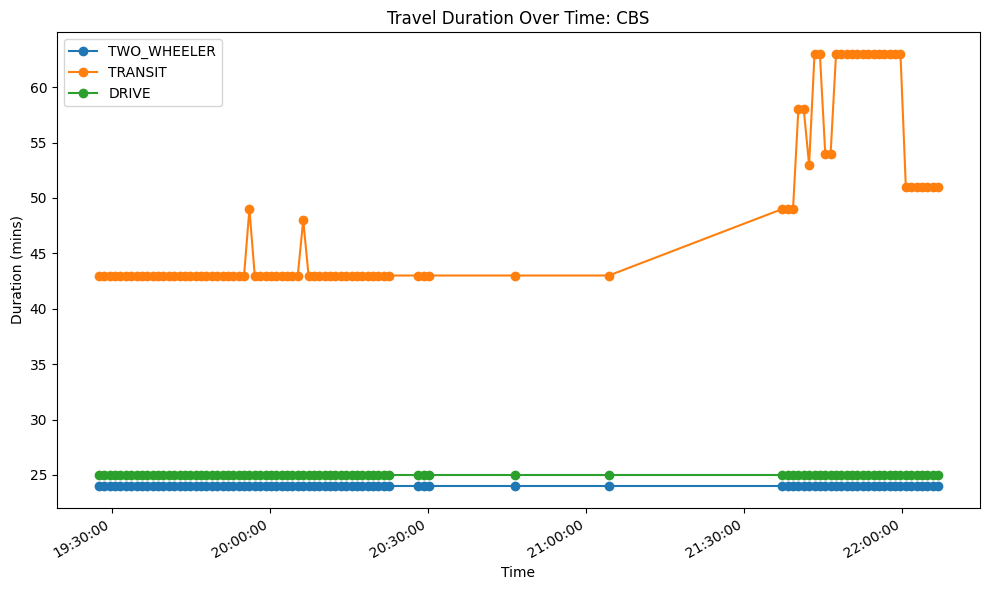

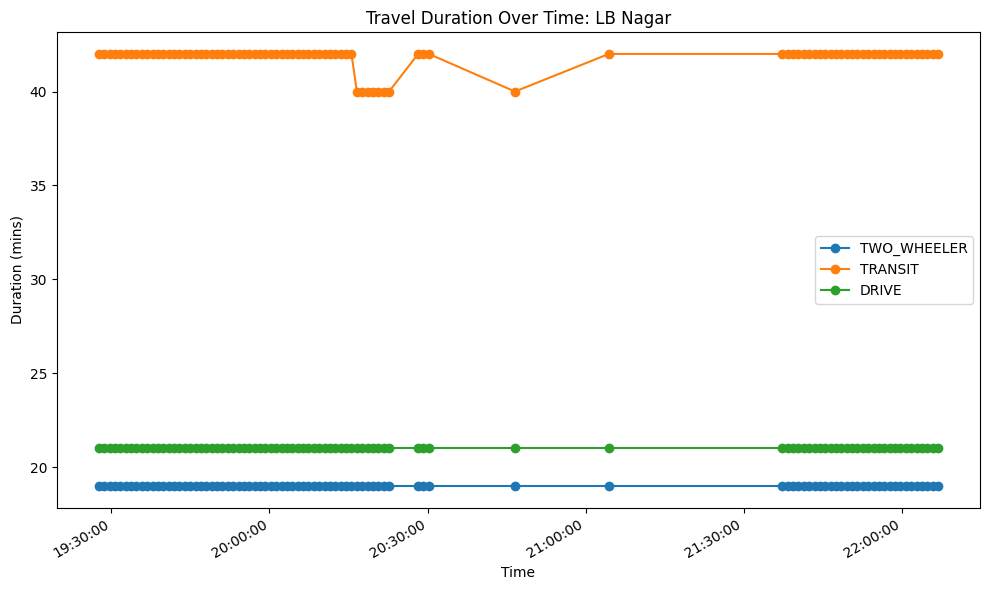

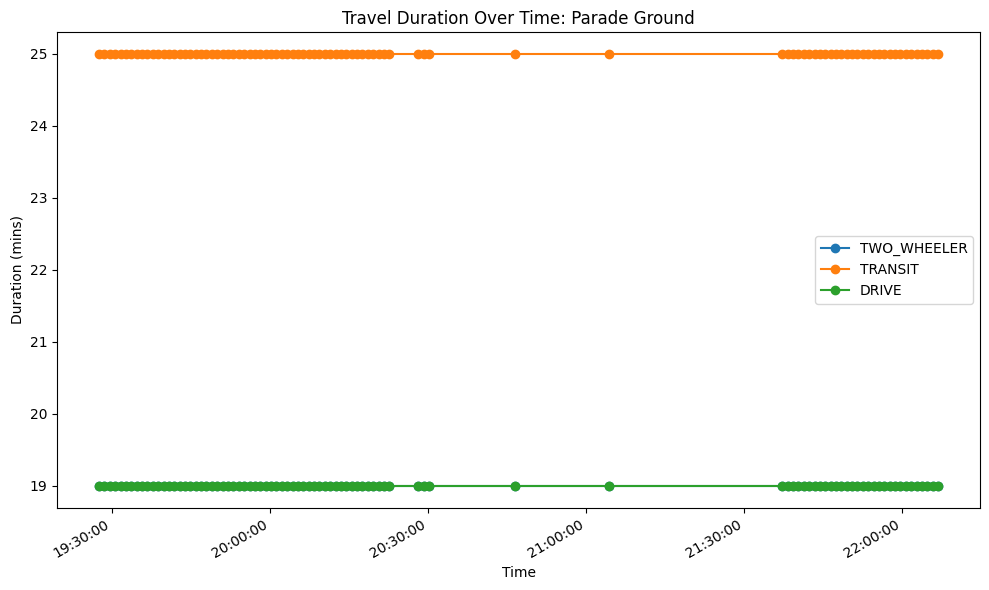

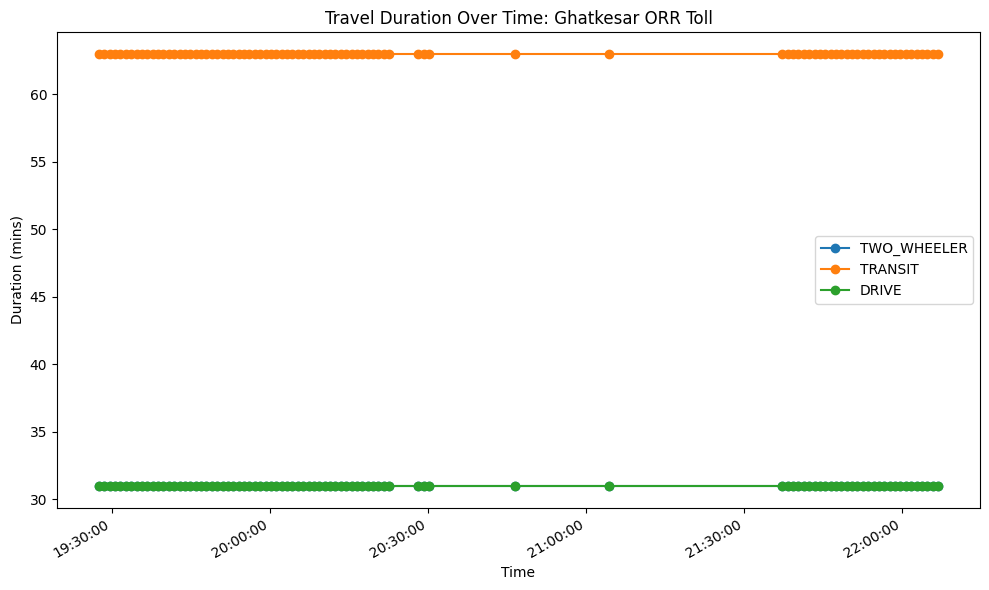

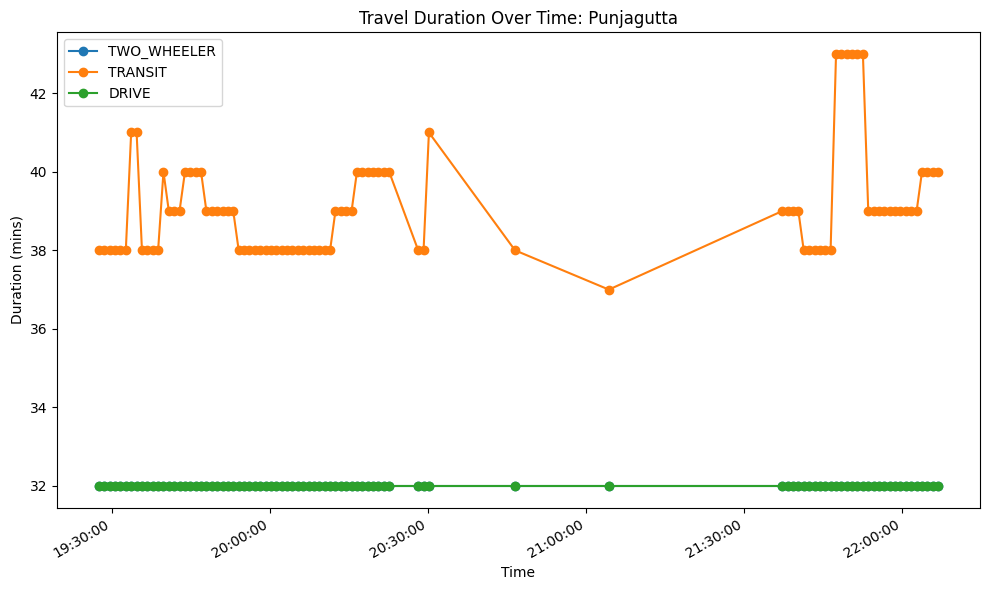

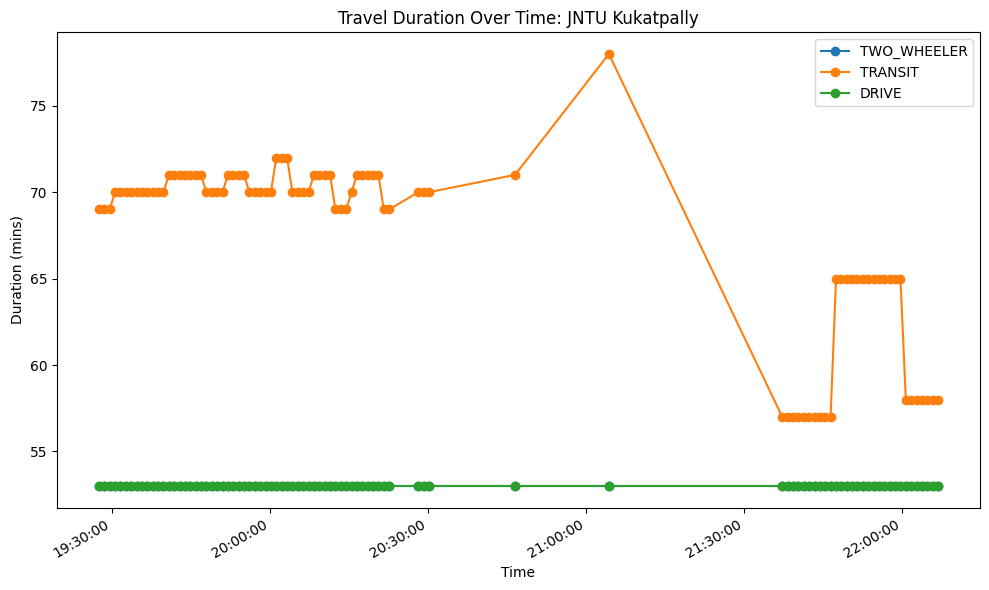

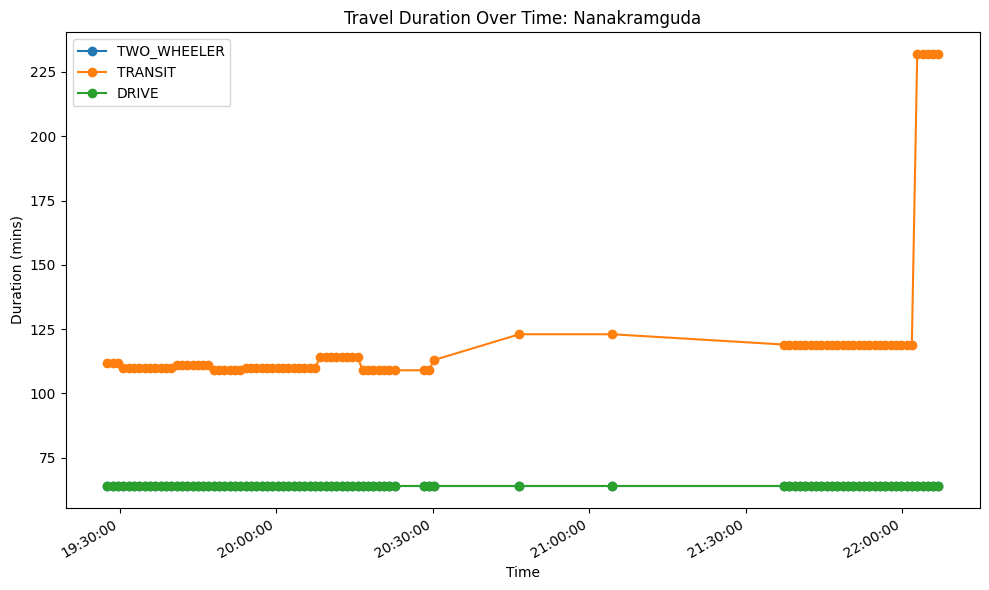

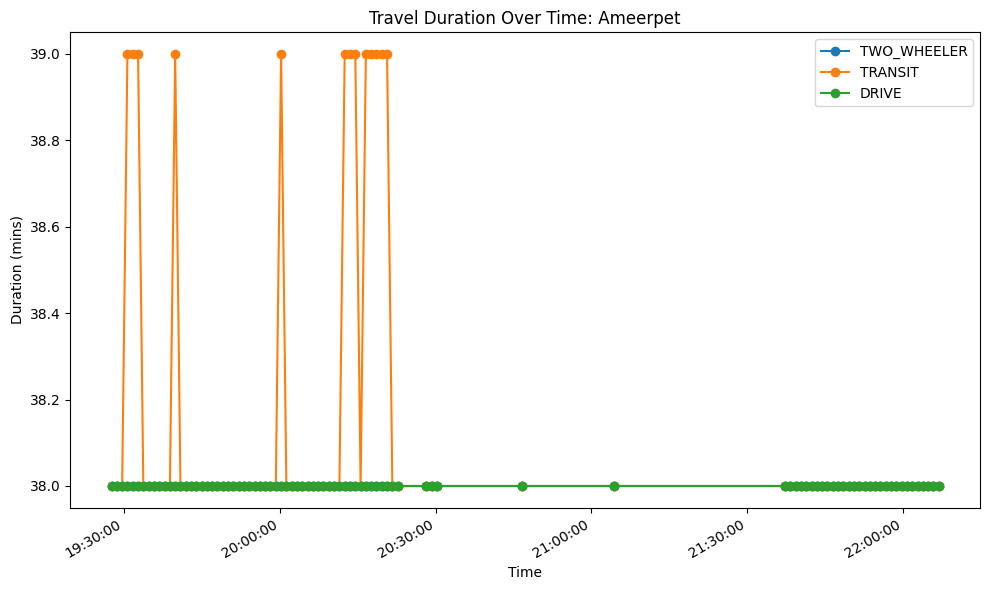

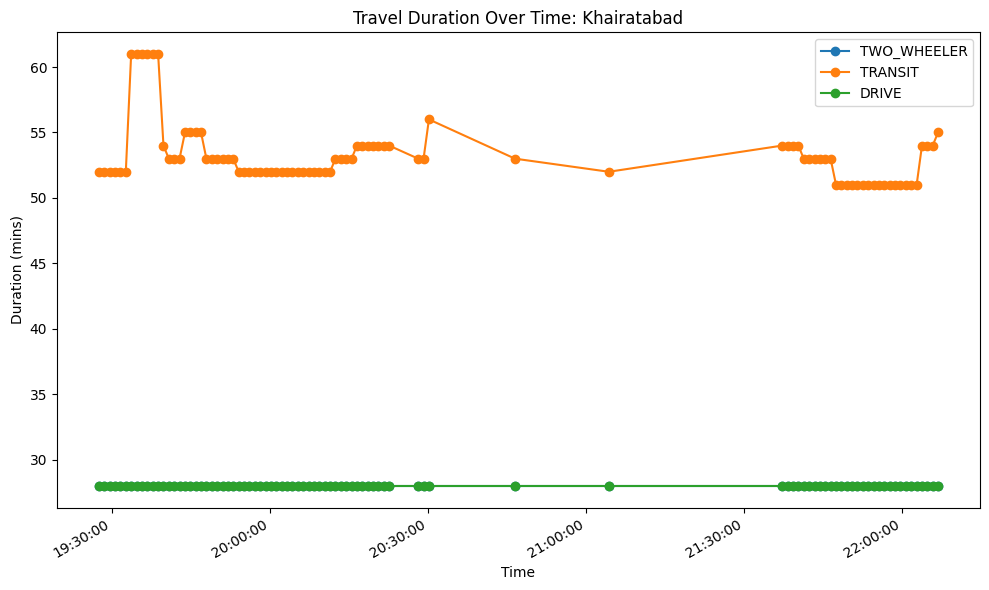

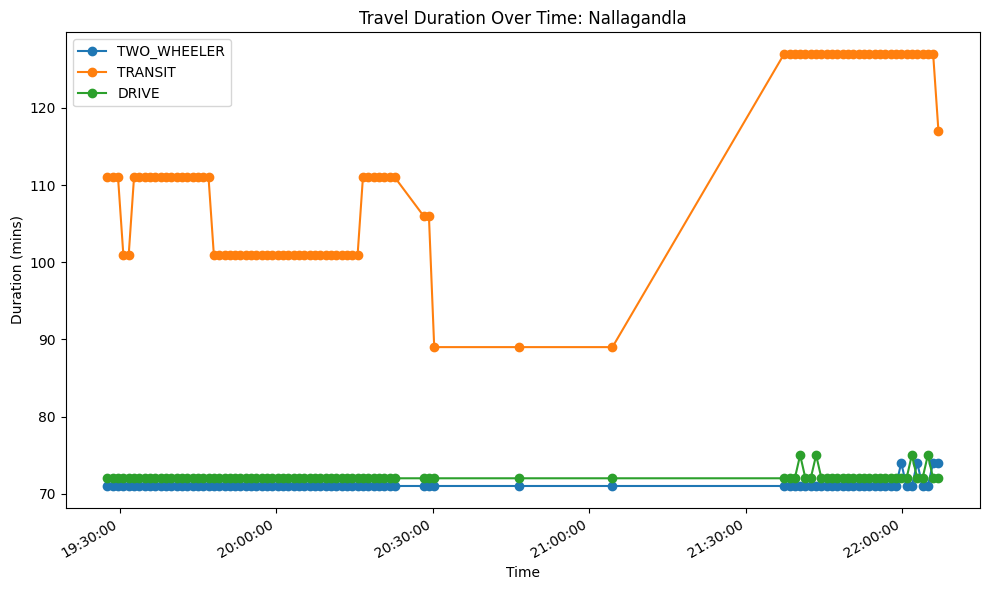

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV file
df = pd.read_csv("travel_times.csv")

# Convert the Timestamp column to datetime objects
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Get a list of unique destinations
destinations = df["Destination"].unique()

# For each destination, create a plot with lines for each travel mode
for dest in destinations:
    # Filter data for this destination
    df_dest = df[df["Destination"] == dest]
    # Get the unique travel modes for this destination
    modes = df_dest["Mode"].unique()
    
    plt.figure(figsize=(10, 6))
    
    for mode in modes:
        # Filter data for the current travel mode and sort by timestamp
        df_mode = df_dest[df_dest["Mode"] == mode].sort_values("Timestamp")
        plt.plot(df_mode["Timestamp"], df_mode["Duration (mins)"],
                 marker="o", label=mode)
    
    plt.title(f"Travel Duration Over Time: {dest}")
    plt.xlabel("Time")
    plt.ylabel("Duration (mins)")
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()